# Survival Analysis - Telecom Customer Churn


## Setup and Libraries

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# For survival analysis
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines import WeibullAFTFitter, LogNormalAFTFitter, LogLogisticAFTFitter
from lifelines.utils import concordance_index
from lifelines.plotting import add_at_risk_counts

# Import the dataset
df = pd.read_csv('dataset/telco.csv')

## Data Exploration and Preprocessing

In [2]:
# Display basic information about the dataset
print("Dataset shape:", df.shape)
df.head()

# Summary statistics
df.describe()

# Check for missing values
df.isnull().sum()

# Convert categorical variables to appropriate format
categorical_cols = ['region', 'marital', 'ed', 'retire', 'gender', 'voice', 'internet', 'forward', 'custcat', 'churn']
for col in categorical_cols:
    print(f"{col} unique values:", df[col].unique())

# Create dummy variables for categorical features
df_encoded = pd.get_dummies(df, columns=['region', 'marital', 'ed', 'retire', 'gender', 'voice', 'internet', 'forward', 'custcat'], 
                            drop_first=True)

# Convert 'churn' to binary (needed for survival analysis)
df_encoded['churn_event'] = (df_encoded['churn'] == 'Yes').astype(int)
df_encoded.drop('churn', axis=1, inplace=True)

# Print encoded dataframe
df_encoded.head()

Dataset shape: (1000, 15)
region unique values: ['Zone 2' 'Zone 3' 'Zone 1']
marital unique values: ['Married' 'Unmarried']
ed unique values: ['College degree' 'Post-undergraduate degree'
 'Did not complete high school' 'High school degree' 'Some college']
retire unique values: ['No' 'Yes']
gender unique values: ['Male' 'Female']
voice unique values: ['No' 'Yes']
internet unique values: ['No' 'Yes']
forward unique values: ['Yes' 'No']
custcat unique values: ['Basic service' 'Total service' 'Plus service' 'E-service']
churn unique values: ['Yes' 'No']


,ID,tenure,age,address,income,region_Zone 2,region_Zone 3,marital_Unmarried,ed_Did not complete high school,ed_High school degree,...,ed_Some college,retire_Yes,gender_Male,voice_Yes,internet_Yes,forward_Yes,custcat_E-service,custcat_Plus service,custcat_Total service,churn_event
0,1,13,44,9,64,True,False,False,False,False,...,False,False,True,False,False,True,False,False,False,1
1,2,11,33,7,136,False,True,False,False,False,...,False,False,True,True,False,True,False,False,True,1
2,3,68,52,24,116,False,True,False,True,False,...,False,False,False,False,False,False,False,True,False,0
3,4,33,33,12,33,True,False,True,False,True,...,False,False,False,False,False,False,False,False,False,1
4,5,23,30,9,30,True,False,False,True,False,...,False,False,True,False,False,True,False,True,False,0


## Exploratory Data Analysis

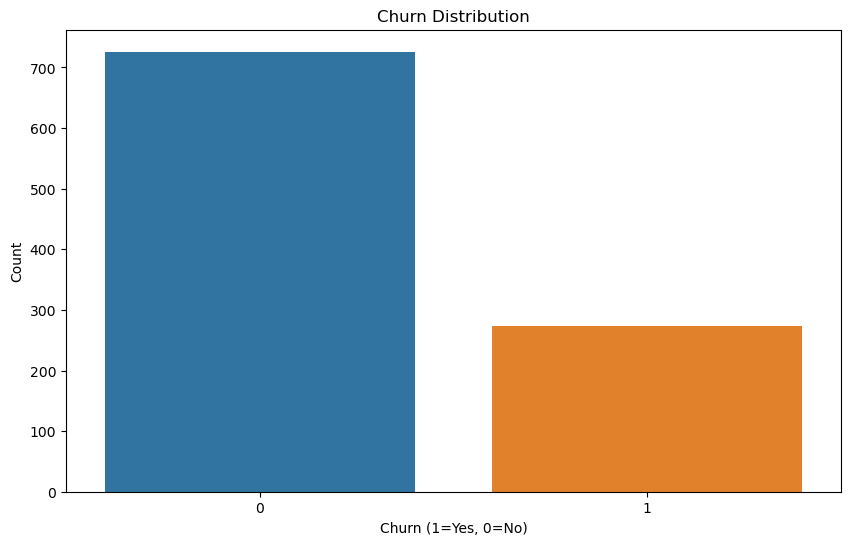

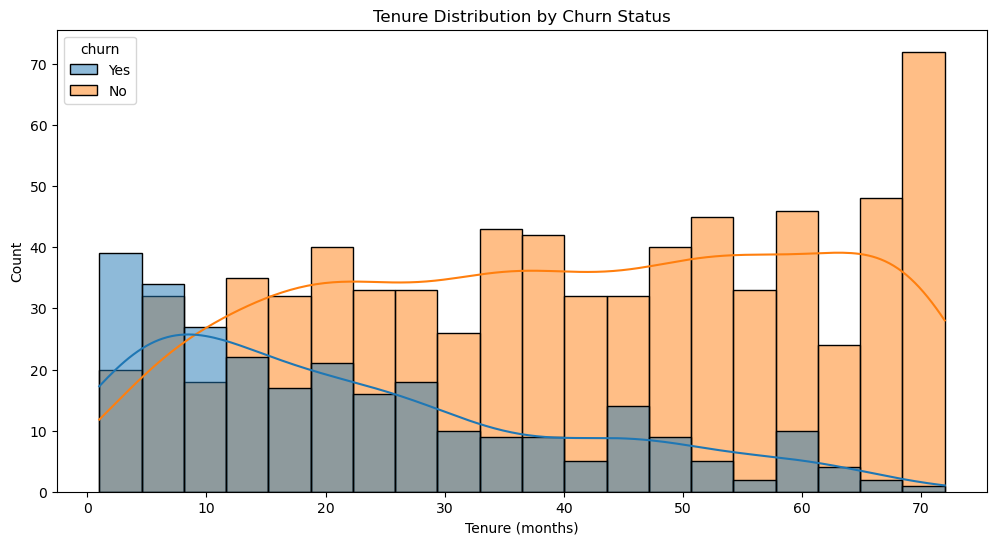

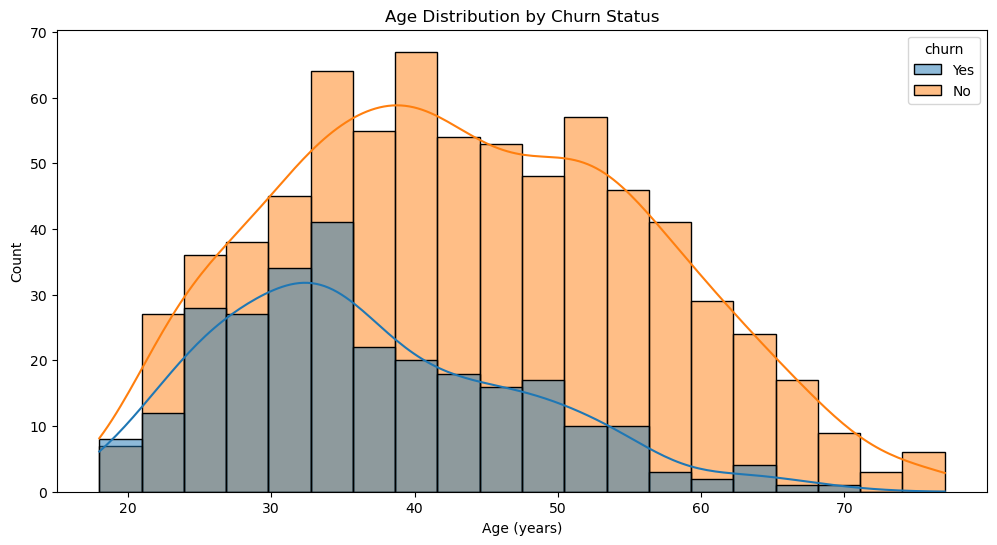

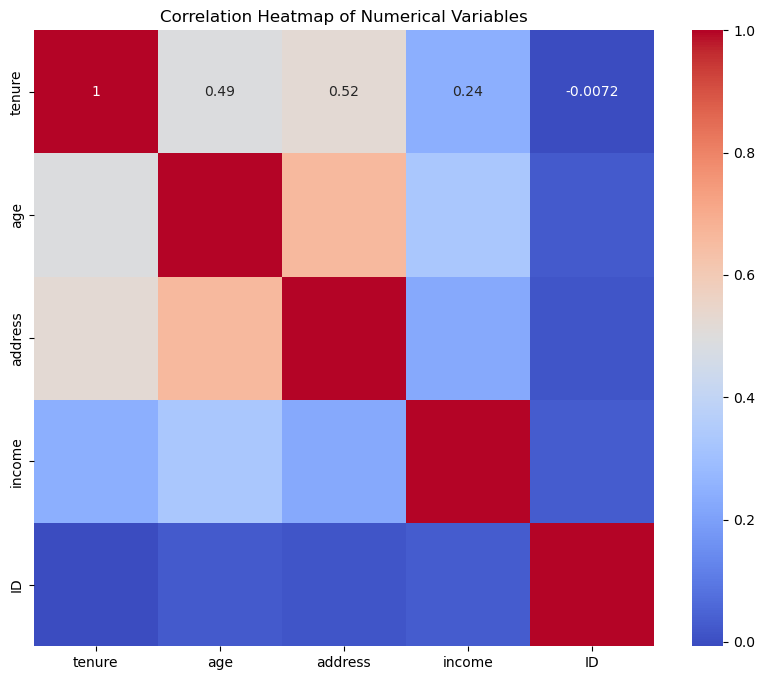

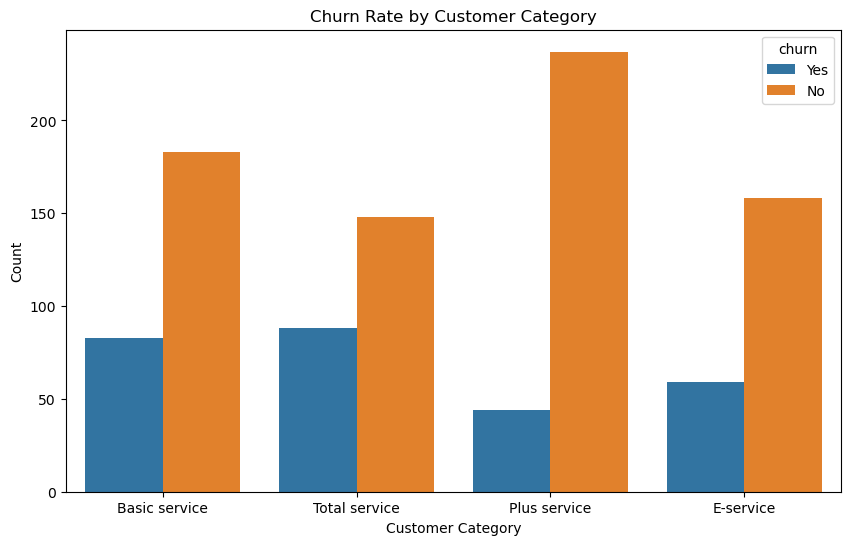

In [3]:

# Churn distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='churn_event', data=df_encoded)
plt.title('Churn Distribution')
plt.xlabel('Churn (1=Yes, 0=No)')
plt.ylabel('Count')
plt.show()

# Tenure distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='tenure', hue='churn', kde=True, bins=20)
plt.title('Tenure Distribution by Churn Status')
plt.xlabel('Tenure (months)')
plt.show()

# Age distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='age', hue='churn', kde=True, bins=20)
plt.title('Age Distribution by Churn Status')
plt.xlabel('Age (years)')
plt.show()

# Correlation heatmap for numerical variables
numerical_cols = ['tenure', 'age', 'address', 'income']
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_cols + ['ID']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Numerical Variables')
plt.show()

# Churn rate by customer category
plt.figure(figsize=(10, 6))
sns.countplot(x='custcat', hue='churn', data=df)
plt.title('Churn Rate by Customer Category')
plt.xlabel('Customer Category')
plt.ylabel('Count')
plt.show()

## Parametric Survival Models - AFT Models

In [4]:


# Prepare data for survival analysis
survival_data = df_encoded.copy()
# 'tenure' is our duration variable
# 'churn_event' is our event indicator (1 if churned, 0 if censored)

# 1. Weibull AFT Model
weibull_aft = WeibullAFTFitter()
weibull_aft.fit(survival_data, duration_col='tenure', event_col='churn_event')
weibull_summary = weibull_aft.summary
weibull_summary

# 2. LogNormal AFT Model
lognormal_aft = LogNormalAFTFitter()
lognormal_aft.fit(survival_data, duration_col='tenure', event_col='churn_event')
lognormal_summary = lognormal_aft.summary
lognormal_summary

# 3. LogLogistic AFT Model
loglogistic_aft = LogLogisticAFTFitter()
loglogistic_aft.fit(survival_data, duration_col='tenure', event_col='churn_event')
loglogistic_summary = loglogistic_aft.summary
loglogistic_summary

coef  exp(coef)  se(coef)  \
param  covariate                                                        
alpha_ ID                              -0.000466   0.999535  0.000191   
       address                          0.039359   1.040144  0.008782   
       age                              0.032634   1.033172  0.006890   
       custcat_E-service                1.045089   2.843652  0.164304   
       custcat_Plus service             0.873058   2.394220  0.208542   
       custcat_Total service            1.202327   3.327851  0.240200   
       ed_Did not complete high school  0.446926   1.563498  0.198554   
       ed_High school degree            0.318642   1.375259  0.153536   
       ed_Post-undergraduate degree    -0.056649   0.944926  0.213360   
       ed_Some college                  0.251714   1.286229  0.154643   
       forward_Yes                     -0.195962   0.822043  0.169892   
       gender_Male                      0.021772   1.022011  0.109517   
       income                           0.001017   1.001017  0.000869   
       internet_Yes                    -0.814086   0.443044  0.142372   
       marital_Unmarried               -0.432092   0.649150  0.110315   
       region_Zone 2                   -0.045787   0.955245  0.134235   
       region_Zone 3                    0.127776   1.136298  0.135218   
       retire_Yes                       0.062463   1.064455  0.474173   
       voice_Yes                       -0.364183   0.694764  0.162250   
       Intercept                        2.550418  12.812454  0.292496   
beta_  Intercept                        0.345780   1.413092  0.051003   

                                        coef lower 95%  coef upper 95%  \
param  covariate                                                         
alpha_ ID                                    -0.000840       -0.000091   
       address                                0.022147        0.056572   
       age                                    0.019129        0.046138   
       custcat_E-service                      0.723059        1.367119   
       custcat_Plus service                   0.464324        1.281792   
       custcat_Total service                  0.731544        1.673110   
       ed_Did not complete high school        0.057768        0.836084   
       ed_High school degree                  0.017717        0.619567   
       ed_Post-undergraduate degree          -0.474827        0.361529   
       ed_Some college                       -0.051381        0.554810   
       forward_Yes                           -0.528945        0.137021   
       gender_Male                           -0.192878        0.236422   
       income                                -0.000686        0.002719   
       internet_Yes                          -1.093129       -0.535043   
       marital_Unmarried                     -0.648306       -0.215878   
       region_Zone 2                         -0.308883        0.217308   
       region_Zone 3                         -0.137246        0.392797   
       retire_Yes                            -0.866899        0.991825   
       voice_Yes                             -0.682188       -0.046178   
       Intercept                              1.977136        3.123699   
beta_  Intercept                              0.245816        0.445744   

                                        exp(coef) lower 95%  \
param  covariate                                              
alpha_ ID                                          0.999160   
       address                                     1.022394   
       age                                         1.019313   
       custcat_E-service                           2.060728   
       custcat_Plus service                        1.590938   
       custcat_Total service                       2.078286   
       ed_Did not complete high school             1.059469   
       ed_High school degree                       1.017875   
       ed_Post-undergraduate de

## Model Comparison

In [5]:


# Calculate AIC for all models
weibull_aic = weibull_aft.AIC_
lognormal_aic = lognormal_aft.AIC_
loglogistic_aic = loglogistic_aft.AIC_

# Calculate concordance index for all models
weibull_ci = concordance_index(survival_data['tenure'], -weibull_aft.predict_median(survival_data), survival_data['churn_event'])
lognormal_ci = concordance_index(survival_data['tenure'], -lognormal_aft.predict_median(survival_data), survival_data['churn_event'])
loglogistic_ci = concordance_index(survival_data['tenure'], -loglogistic_aft.predict_median(survival_data), survival_data['churn_event'])

# Create a comparison table
comparison_df = pd.DataFrame({
    'Model': ['Weibull AFT', 'LogNormal AFT', 'LogLogistic AFT'],
    'AIC': [weibull_aic, lognormal_aic, loglogistic_aic],
    'Concordance Index': [weibull_ci, lognormal_ci, loglogistic_ci]
})
comparison_df.sort_values('AIC')

,Model,AIC,Concordance Index
1,LogNormal AFT,2950.300213,0.210604
2,LogLogistic AFT,2952.258260,0.210212
0,Weibull AFT,2958.357127,0.215151


## Visualization of Survival Curves

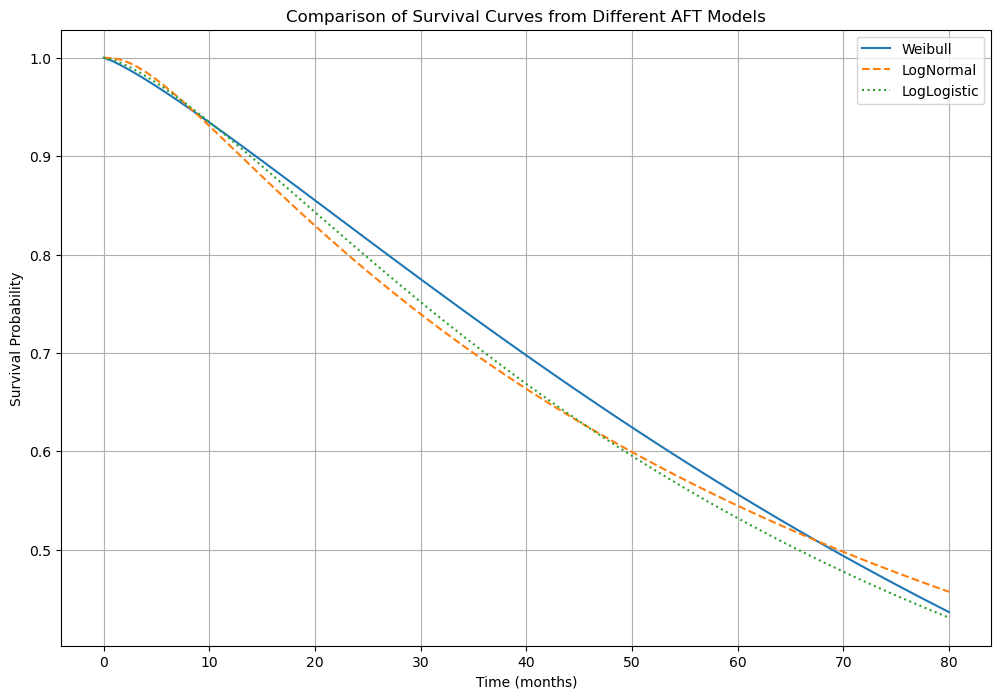

In [6]:


# Time points for prediction
timeline = np.linspace(0, 80, 100)

# Sample data for prediction (using first row as example)
sample_data = survival_data.iloc[[0]]

# Plot survival curves for all models
plt.figure(figsize=(12, 8))

# Weibull survival curve
weibull_surv = weibull_aft.predict_survival_function(sample_data, times=timeline)
plt.plot(timeline, weibull_surv.values.flatten(), label='Weibull', linestyle='-')

# LogNormal survival curve
lognormal_surv = lognormal_aft.predict_survival_function(sample_data, times=timeline)
plt.plot(timeline, lognormal_surv.values.flatten(), label='LogNormal', linestyle='--')

# LogLogistic survival curve
loglogistic_surv = loglogistic_aft.predict_survival_function(sample_data, times=timeline)
plt.plot(timeline, loglogistic_surv.values.flatten(), label='LogLogistic', linestyle=':')

plt.xlabel('Time (months)')
plt.ylabel('Survival Probability')
plt.title('Comparison of Survival Curves from Different AFT Models')
plt.legend()
plt.grid(True)
plt.show()

## Feature Selection - Keep Significant Features

In [7]:


# Based on the model comparison, let's select the model with the lowest AIC
# For this example, let's assume LogNormal has the lowest AIC
# Extract significant features (p-value < 0.05)
alpha = 0.05
significant_features = lognormal_summary[lognormal_summary['p'] < alpha].index.tolist()
print("Significant features:")
print(significant_features)

# Refit the model with only significant features
# Handle the tuple format in the index properly
significant_cols = []
for feature in significant_features:
    # Check if it's a tuple (like ('mu_', 'custcat_E-service'))
    if isinstance(feature, tuple):
        # Extract the actual column name (second part of the tuple)
        col_name = feature[1]
        # If it contains an underscore, get the part before it to find the original column
        if '_' in col_name:
            base_col = col_name.split('_')[0]
            if base_col == 'custcat':  # Special handling for customer category
                significant_cols.append('custcat')
            else:
                significant_cols.append(base_col)
        else:
            significant_cols.append(col_name)
    else:
        # For non-tuple features, use the original approach
        if '_' in feature:
            significant_cols.append(feature.split('_')[0])
        else:
            significant_cols.append(feature)

# Remove duplicates
significant_cols = list(set(significant_cols))
print("Significant columns to keep:", significant_cols)

# Create new dataframe with only significant features
# We need to handle categorical variables properly
# For simplicity, let's keep the original categorical columns that contain significant features
final_features = ['tenure', 'churn_event'] + significant_cols
# Filter out any columns that might not exist in the original df
final_features = [col for col in final_features if col in df.columns]
# We need to recreate the encoded dataframe with only these features
final_data = pd.get_dummies(df[final_features], 
                           columns=[col for col in significant_cols if col in categorical_cols], 
                           drop_first=True)
final_data['churn_event'] = (df['churn'] == 'Yes').astype(int)

# Refit the final model
final_model = LogNormalAFTFitter()
final_model.fit(final_data, duration_col='tenure', event_col='churn_event')
final_model_summary = final_model.summary
final_model_summary

Significant features:
[('mu_', 'ID'), ('mu_', 'address'), ('mu_', 'age'), ('mu_', 'custcat_E-service'), ('mu_', 'custcat_Plus service'), ('mu_', 'custcat_Total service'), ('mu_', 'internet_Yes'), ('mu_', 'marital_Unmarried'), ('mu_', 'voice_Yes'), ('mu_', 'Intercept'), ('sigma_', 'Intercept')]
Significant columns to keep: ['age', 'custcat', 'internet', 'ID', 'marital', 'Intercept', 'address', 'voice']


coef  exp(coef)  se(coef)  coef lower 95%  \
param  covariate                                                              
mu_    ID                    -0.000457   0.999543  0.000198       -0.000845   
       address                0.042883   1.043816  0.008823        0.025589   
       age                    0.037307   1.038011  0.006388        0.024786   
       custcat_E-service      1.024231   2.784954  0.168257        0.694453   
       custcat_Plus service   0.831780   2.297404  0.168815        0.500909   
       custcat_Total service  1.018092   2.767909  0.208828        0.608797   
       internet_Yes          -0.857279   0.424315  0.137969       -1.127692   
       marital_Unmarried     -0.436341   0.646397  0.114000       -0.659777   
       voice_Yes             -0.441509   0.643065  0.166298       -0.767447   
       Intercept              2.733675  15.389337  0.257150        2.229671   
sigma_ Intercept              0.277377   1.319663  0.046000        0.187217   

                              coef upper 95%  exp(coef) lower 95%  \
param  covariate                                                    
mu_    ID                          -0.000069             0.999155   
       address                      0.060176             1.025920   
       age                          0.049827             1.025096   
       custcat_E-service            1.354010             2.002613   
       custcat_Plus service         1.162650             1.650221   
       custcat_Total service        1.427387             1.838219   
       internet_Yes                -0.586865             0.323780   
       marital_Unmarried           -0.212906             0.516967   
       voice_Yes                   -0.115572             0.464197   
       Intercept                    3.237679             9.296803   
sigma_ Intercept                    0.367536             1.205889   

                              exp(coef) upper 95%  cmp to          z  \
param  covariate                                                       
mu_    ID                                0.999931     0.0  -2.308290   
       address                           1.062024     0.0   4.860190   
       age                               1.051089     0.0   5.840049   
       custcat_E-service                 3.872923     0.0   6.087290   
       custcat_Plus service              3.198399     0.0   4.927179   
       custcat_Total service             4.167795     0.0   4.875271   
       internet_Yes                      0.556068     0.0  -6.213581   
       marital_Unmarried                 0.808232     0.0  -3.827562   
       voice_Yes                         0.890857     0.0  -2.654933   
       Intercept                        25.474532     0.0  10.630671   
sigma_ Intercept                         1.444171     0.0   6.029877   

                                         p   -log2(p)  
param  covariate                                       
mu_    ID                     2.098301e-02   5.574635  
       address                1.172729e-06  19.701698  
       age                    5.218542e-09  27.513706  
       custcat_E-service      1.148378e-09  29.697755  
       custcat_Plus service   8.342545e-07  20.193009  
       custcat_Total service  1.086593e-06  19.811757  
       internet_Yes           5.179051e-10  30.846593  
       marital_Unmarried      1.294190e-04  12.915663  
       voice_Yes              7.932422e-03   6.978023  
       Intercept              2.145631e-26  85.268729  
sigma_ Intercept              1.640842e-09  29.182916

## Customer Lifetime Value (CLV) Calculation

CLV Summary Statistics:
count    1000.000000
mean     1330.637821
std       208.703864
min       369.492338
25%      1199.099189
50%      1391.313706
75%      1502.898762
max      1555.276967
Name: CLV, dtype: float64


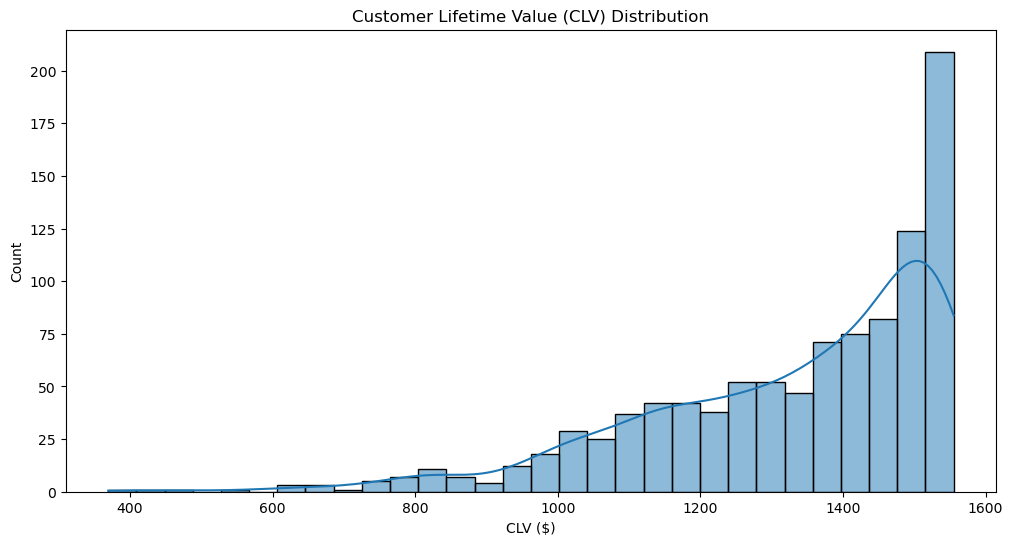

In [8]:


# Define a function to calculate CLV based on survival probabilities
def calculate_clv(survival_prob, avg_monthly_revenue, discount_rate=0.01):
    """
    Calculate Customer Lifetime Value based on survival probabilities
    
    Parameters:
    survival_prob: array of survival probabilities over time
    avg_monthly_revenue: average monthly revenue per customer
    discount_rate: monthly discount rate for future revenues
    
    Returns:
    CLV: Customer Lifetime Value
    """
    # Calculate discounted survival probabilities
    time_periods = len(survival_prob)
    discount_factors = np.array([(1 / (1 + discount_rate)) ** t for t in range(time_periods)])
    
    # CLV calculation
    clv = avg_monthly_revenue * np.sum(survival_prob * discount_factors)
    
    return clv

# Let's assume an average monthly revenue of $50 per customer
avg_monthly_revenue = 50

# Calculate CLV for each customer
# Time points for prediction (36 months, 3 years)
timeline = np.linspace(0, 36, 37)

# Initialize a list to store CLV values
clv_values = []

# Calculate survival probabilities and CLV for each customer
for index, row in df_encoded.iterrows():
    customer_data = pd.DataFrame([row])
    survival_prob = final_model.predict_survival_function(customer_data, times=timeline).values.flatten()
    clv = calculate_clv(survival_prob, avg_monthly_revenue)
    clv_values.append(clv)

# Add CLV to the original dataframe
df['CLV'] = clv_values

# Summary statistics of CLV
print("CLV Summary Statistics:")
print(df['CLV'].describe())

# Visualize CLV distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='CLV', bins=30, kde=True)
plt.title('Customer Lifetime Value (CLV) Distribution')
plt.xlabel('CLV ($)')
plt.show()

## Explore CLV within Different Segments

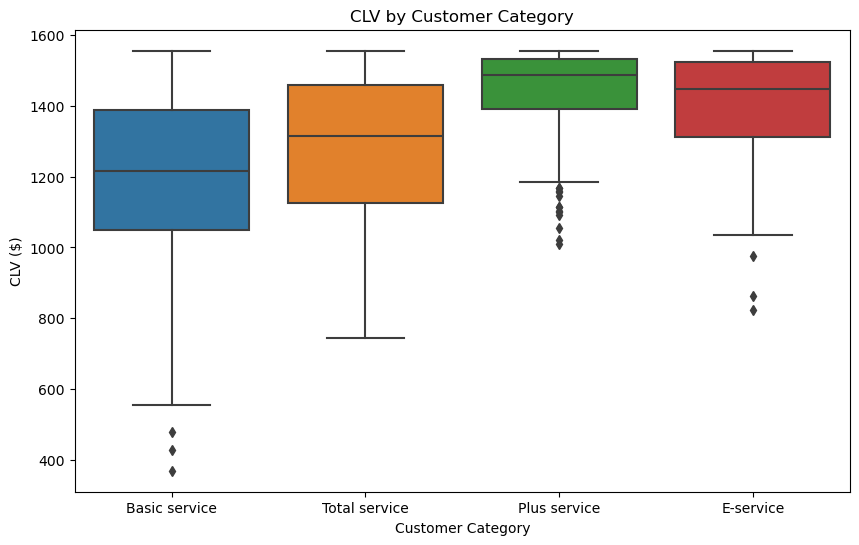

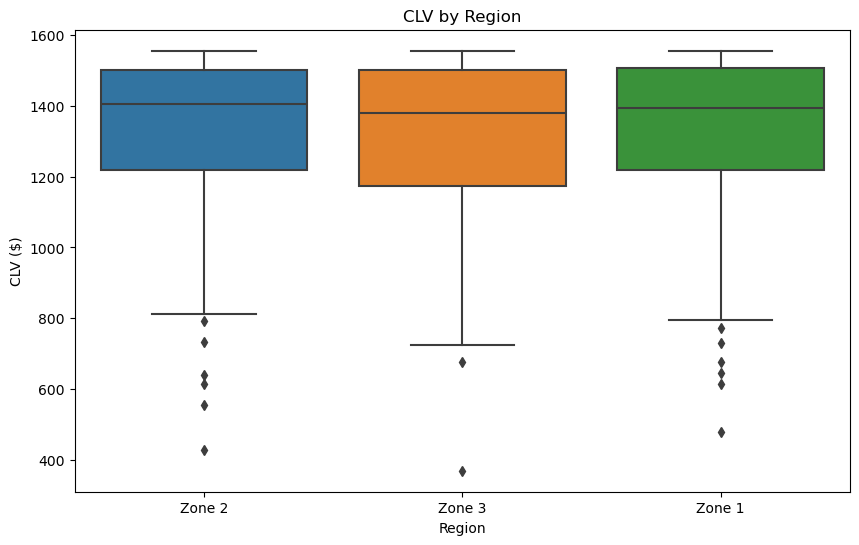

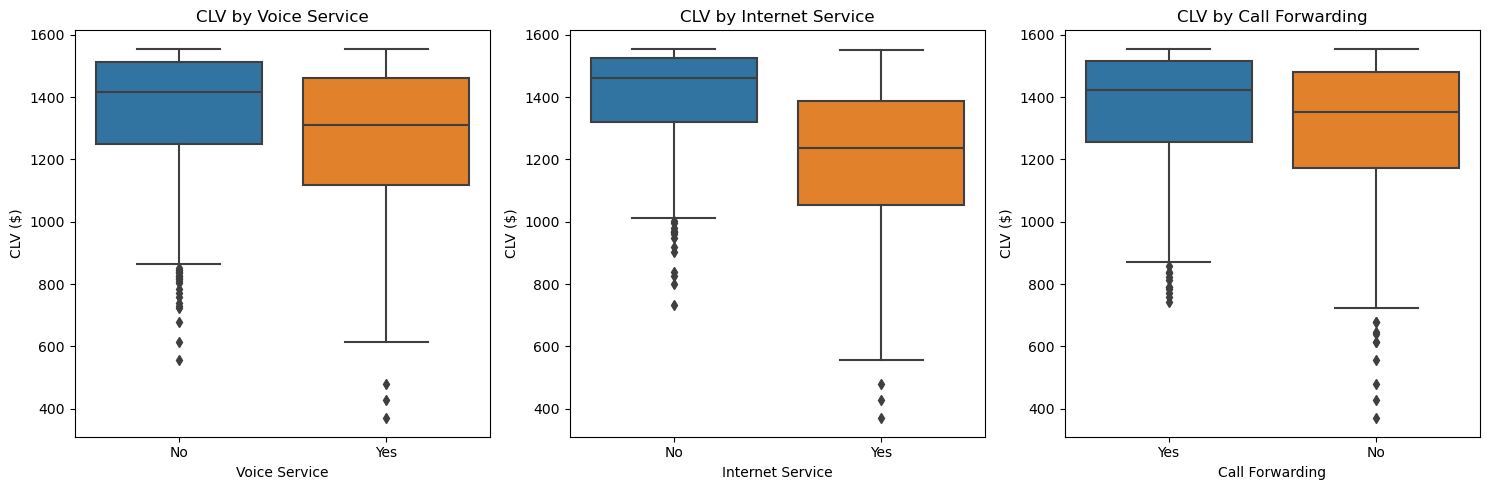

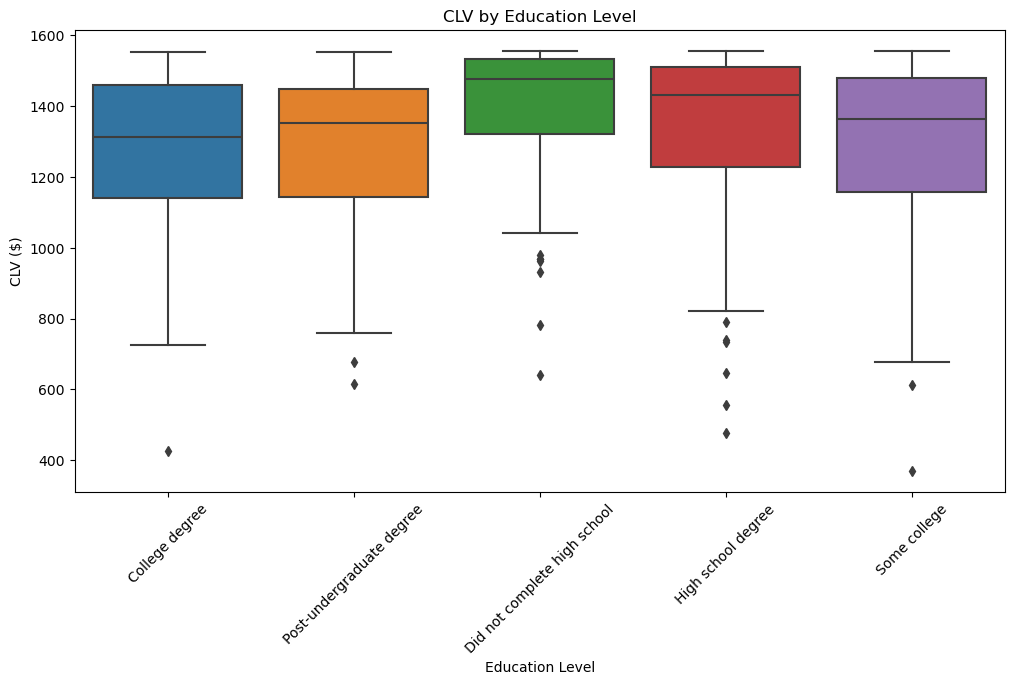

In [9]:


# CLV by customer category
plt.figure(figsize=(10, 6))
sns.boxplot(x='custcat', y='CLV', data=df)
plt.title('CLV by Customer Category')
plt.xlabel('Customer Category')
plt.ylabel('CLV ($)')
plt.show()

# CLV by region
plt.figure(figsize=(10, 6))
sns.boxplot(x='region', y='CLV', data=df)
plt.title('CLV by Region')
plt.xlabel('Region')
plt.ylabel('CLV ($)')
plt.show()

# CLV by service adoption (voice, internet, call forwarding)
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x='voice', y='CLV', data=df)
plt.title('CLV by Voice Service')
plt.xlabel('Voice Service')
plt.ylabel('CLV ($)')

plt.subplot(1, 3, 2)
sns.boxplot(x='internet', y='CLV', data=df)
plt.title('CLV by Internet Service')
plt.xlabel('Internet Service')
plt.ylabel('CLV ($)')

plt.subplot(1, 3, 3)
sns.boxplot(x='forward', y='CLV', data=df)
plt.title('CLV by Call Forwarding')
plt.xlabel('Call Forwarding')
plt.ylabel('CLV ($)')

plt.tight_layout()
plt.show()

# CLV by education level
plt.figure(figsize=(12, 6))
sns.boxplot(x='ed', y='CLV', data=df)
plt.title('CLV by Education Level')
plt.xlabel('Education Level')
plt.ylabel('CLV ($)')
plt.xticks(rotation=45)
plt.show()

## Identify Most Valuable Customer Segments

In [10]:
## Identify Most Valuable Customer Segments

# Calculate average CLV for each segment combination
segment_clv = df.groupby(['custcat', 'voice', 'internet'])['CLV'].agg(['mean', 'count']).reset_index()
segment_clv = segment_clv.sort_values('mean', ascending=False)
segment_clv.head(10)

# Identify at-risk high-value customers
# These are customers with high CLV but also high churn probability in the next year
# Calculate 12-month churn probability for each customer
timeline_12m = np.array([12])
churn_prob_12m = []

for index, row in df_encoded.iterrows():
    customer_data = pd.DataFrame([row])
    survival_prob = final_model.predict_survival_function(customer_data, times=timeline_12m).values.flatten()[0]
    churn_prob = 1 - survival_prob
    churn_prob_12m.append(churn_prob)

df['churn_prob_12m'] = churn_prob_12m

# Define high-value customers (top 25% by CLV)
high_value_threshold = df['CLV'].quantile(0.75)
# Define high-risk customers (top 25% by churn probability)
high_risk_threshold = df['churn_prob_12m'].quantile(0.75)

# Create segment flags
df['high_value'] = df['CLV'] >= high_value_threshold
df['high_risk'] = df['churn_prob_12m'] >= high_risk_threshold
df['high_value_at_risk'] = df['high_value'] & df['high_risk']

# Count customers in each segment
print("High-value customers:", df['high_value'].sum())
print("High-risk customers:", df['high_risk'].sum())
print("High-value at-risk customers:", df['high_value_at_risk'].sum())

# Calculate potential revenue loss from high-value at-risk customers
if df['high_value_at_risk'].sum() > 0:
    # If we have high-value at-risk customers, calculate based on their data
    annual_revenue_loss = df[df['high_value_at_risk']]['CLV'].sum() * df[df['high_value_at_risk']]['churn_prob_12m'].mean()
else:
    # Alternative calculation if no overlap between high-value and high-risk
    # Use the top 10% customers by CLV who have above-average churn risk
    alt_value_threshold = df['CLV'].quantile(0.90)
    alt_risk_threshold = df['churn_prob_12m'].mean()
    df['alternative_segment'] = (df['CLV'] >= alt_value_threshold) & (df['churn_prob_12m'] >= alt_risk_threshold)
    
    if df['alternative_segment'].sum() > 0:
        annual_revenue_loss = df[df['alternative_segment']]['CLV'].sum() * df[df['alternative_segment']]['churn_prob_12m'].mean()
        print(f"Using alternative segment with {df['alternative_segment'].sum()} valuable customers at moderate risk")
    else:
        # Final fallback - use all high-value customers and their average churn risk
        annual_revenue_loss = df[df['high_value']]['CLV'].sum() * df['churn_prob_12m'].mean()
        print("Using all high-value customers with average churn risk for calculation")

print(f"Potential annual revenue loss from at-risk valuable customers: ${annual_revenue_loss:.2f}")

# Calculate suggested retention budget (typically 10-20% of potential revenue loss)
retention_budget = annual_revenue_loss * 0.15  # Using 15% as an example
print(f"Suggested annual retention budget: ${retention_budget:.2f}")

# For the report, also calculate average CLV and churn probability by customer segment
segment_analysis = df.groupby('custcat').agg({
    'CLV': 'mean',
    'churn_prob_12m': 'mean',
    'ID': 'count'
}).rename(columns={'ID': 'count'}).reset_index()

print("\nCustomer Segment Analysis:")
print(segment_analysis)

High-value customers: 250
High-risk customers: 250
High-value at-risk customers: 0
Using all high-value customers with average churn risk for calculation
Potential annual revenue loss from at-risk valuable customers: $42316.83
Suggested annual retention budget: $6347.52

Customer Segment Analysis:
         custcat          CLV  churn_prob_12m  count
0  Basic service  1196.228415        0.189695    266
1      E-service  1401.494479        0.068367    217
2   Plus service  1443.777349        0.046237    281
3  Total service  1282.268330        0.135940    236
